In [30]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

In [ ]:
############################################
# 1) Определяем GRU-модель с авторегрессией
############################################

class EMGDecoderGRU(nn.Module):
    def __init__(self, feat_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        # GRUCell — шаг авторегрессии
        self.gru_cell = nn.GRUCell(feat_dim + output_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

    def forward_step(self, features: torch.Tensor,
                     prev_output: torch.Tensor,
                     hidden: torch.Tensor = None):
        # features: (batch, feat_dim)
        # prev_output: (batch, output_dim)
        # hidden: (batch, hidden_dim) или None
        if hidden is None:
            hidden = torch.zeros(features.size(0), self.hidden_dim,
                                 device=features.device)
        inp = torch.cat([features, prev_output], dim=1)      # (batch, feat+out)
        new_hidden = self.gru_cell(inp, hidden)              # (batch, hidden_dim)
        pred = self.fc(new_hidden)                           # (batch, output_dim)
        return pred, new_hidden


class EMGDecoderLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int = 1,
        dropout: float = 0.0,
    ):
        """
        input_dim  — размерность признаков окна (после TangentSpace)
        hidden_dim — внутренняя размерность LSTM
        output_dim — число углов (здесь 20)
        num_layers — число слоев LSTM
        dropout    — дропаут между слоями LSTM (если num_layers > 1)
        """
        super().__init__()
        # LSTM обрабатывает одновременно всю подпоследовательность длины seq_len
        # на входе ему подаётся concat(features, prev_outputs) по фичам
        self.lstm = nn.LSTM(
            input_size  = input_dim + output_dim,
            hidden_size = hidden_dim,
            num_layers  = num_layers,
            batch_first = True,
            dropout     = dropout if num_layers > 1 else 0.0,
        )
        # МLP-голова: из hidden_dim → hidden_dim → output_dim
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim),
        )
        self.output_dim = output_dim

    def forward(
        self,
        features: torch.Tensor,
        prev_outputs: torch.Tensor,
        hidden: tuple = None
    ) -> tuple:
        """
        features     — Tensor [batch, seq_len, input_dim]
        prev_outputs — Tensor [batch, seq_len, output_dim]
                        (teacher forcing: при обучении — истинные, при инференсе — смещённые предсказания)
        hidden       — tuple(h0, c0), каждый [num_layers, batch, hidden_dim]
                        либо None (тогда LSTM сам инициализирует нулями)
        Returns:
          preds  — Tensor [batch, seq_len, output_dim]
          hidden — tuple (h_n, c_n) для следующей подпоследовательности или шага
        """
        # 1) Конкатенируем вдоль feature-оси
        #    из ([B, T, D_feat], [B, T, D_out]) → [B, T, D_feat+D_out]
        lstm_in = torch.cat([features, prev_outputs], dim=2)

        # 2) Пропускаем через LSTM
        #    out: [B, T, hidden_dim]; hidden = (h_n, c_n)
        out, hidden = self.lstm(lstm_in, hidden)

        # 3) На каждый временной шаг делаем MLP-предсказание
        preds = self.mlp(out)  # [B, T, output_dim]

        return preds, hidden

In [3]:
############################################
# 2) Функции для нарезки и подготовки
############################################

def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)
    l_idx = int((N_samples * num_of_part) / N_parts)
    return data[:l_idx], data[l_idx:]

def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    ts_samp = int((timestep * fs) / 1000)
    wl_samp = int((windowlen * fs) / 1000)
    start = np.arange(0, data_len - wl_samp, ts_samp)[:, None]
    idxs = start + np.arange(0, wl_samp)[None, :]
    X = data[idxs].transpose(0, 2, 1)
    y = label[start[:, 0] + wl_samp]
    return X, y

def prepare_sequences(X: np.ndarray, y: np.ndarray, seq_len: int):
    # X: (T, feat_dim), y: (T, out_dim)
    T, feat = X.shape
    _, out = y.shape
    n_seq = T - seq_len + 1
    Xs = np.zeros((n_seq, seq_len, feat), dtype=X.dtype)
    Ys = np.zeros((n_seq, seq_len, out), dtype=y.dtype)
    for i in range(n_seq):
        Xs[i] = X[i:i+seq_len]
        Ys[i] = y[i:i+seq_len]
    return Xs, Ys

def prepare_single_sequence(X: np.ndarray, seq_len: int):
    T, feat = X.shape
    if T < seq_len:
        pad = np.zeros((seq_len - T, feat), dtype=X.dtype)
        X = np.vstack([pad, X])
    return X[None, -seq_len:, :]

In [ ]:
############################################
# 3) Наша новая обёртка-регрессор
############################################

class RiemannGRURegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator: str = "oas",
        metric: str = "riemann",
        hidden_dim: int = 64,
        seq_len: int = 20,
        lr: float = 1e-3,
        alpha: float = 1e-5,
        max_iter: int = 50,
        batch_size: int = 32,
        device: str = "cpu",
        verbose: bool = False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.lr = lr
        self.alpha = alpha
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose

        # будут инициализированы в fit
        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(self, X: np.ndarray, y: np.ndarray, X_val=None, y_val=None):
        # X: (n_windows, n_ch, n_time), y: (n_windows, 20)
        # 1) Riemann-признаки
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)  # (T, feat_dim)

        # 2) Переход к numpy, чтобы сформировать sequences
        X_ts_np = X_ts
        y_np = y
        X_seq, y_seq = prepare_sequences(X_ts_np, y_np, self.seq_len)
        # X_seq: (n_seq, seq_len, feat); y_seq: (n_seq, seq_len, 20)

        # 3) В даталоадер подаём X_seq и y_seq
        # Сшиваем по последнему измерению: для каждой позиции t обучаем модель последовательно
        # но DataLoader вернёт полный seq.
        dataset = TensorDataset(
            torch.tensor(X_seq, dtype=torch.float32),
            torch.tensor(y_seq, dtype=torch.float32)
        )
        loader = DataLoader(dataset, batch_size=self.batch_size,
                            shuffle=True, drop_last=True)

        # 4) Создаём модель
        feat_dim = X_ts.shape[1]
        output_dim = y.shape[1]
        self.model_ = EMGDecoderGRU(feat_dim, self.hidden_dim, output_dim).to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model_.parameters(), lr=self.lr,
                               weight_decay=self.alpha)

        # 5) Тренировочный цикл с teacher forcing
        for epoch in range(self.max_iter):
            self.model_.train()
            epoch_loss = 0.0
            for Xb, yb in loader:
                # Xb: (B, seq_len, feat), yb: (B, seq_len, out)
                Xb = Xb.to(self.device)
                yb = yb.to(self.device)
                batch_size = Xb.size(0)

                prev_pred = torch.zeros(batch_size, output_dim, device=self.device)
                hidden = None
                loss_batch = 0.0

                for t in range(self.seq_len):
                    feat_t = Xb[:, t, :]
                    target_t = yb[:, t, :]
                    pred_t, hidden = self.model_.forward_step(feat_t, prev_pred, hidden)
                    loss_batch += criterion(pred_t, target_t)
                    # teacher forcing
                    prev_pred = target_t.detach()

                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
                epoch_loss += loss_batch.item()

            if self.verbose and epoch % 5 == 0:
                # --- Тренировочные метрики ---
                train_preds = self.predict(X)
                mse_train = np.mean((train_preds - y)**2)
                corrs = [np.corrcoef(train_preds[:, i], y[:, i])[0,1] 
                         for i in range(y.shape[1])]
                mean_corr = np.nanmean(corrs)
                r2 = r2_score(y, train_preds)

                msg = (f"Epoch {epoch}/{self.max_iter} | "
                       f"AvgBatchLoss: {epoch_loss/len(loader):.4f} | "
                       f"Train MSE: {mse_train:.4f}, Corr: {mean_corr:.3f}, R2: {r2:.3f}")

                # --- Валидационные метрики (если есть) ---
                if X_val is not None and y_val is not None:
                    val_preds = self.predict(X_val)
                    mse_val = np.mean((val_preds - y_val)**2)
                    corrs_val = [np.corrcoef(val_preds[:, i], y_val[:, i])[0,1]
                                 for i in range(y_val.shape[1])]
                    mean_corr_val = np.nanmean(corrs_val)
                    r2_val = r2_score(y_val, val_preds)
                    msg += (f" | Val MSE: {mse_val:.4f}, Corr: {mean_corr_val:.3f}, "
                            f"R2: {r2_val:.3f}")

                print(msg)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Блочное предсказание (batch of windows), но без teacher forcing:
        # 1) ковариации → ts
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)  # (T, feat_dim)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)

        self.model_.eval()
        preds = []
        prev_pred = torch.zeros(1, self.model_.output_dim, device=self.device)
        hidden = None

        with torch.no_grad():
            for feat in X_ts:
                feat = feat.unsqueeze(0)  # (1, feat_dim)
                pred_t, hidden = self.model_.forward_step(feat, prev_pred, hidden)
                preds.append(pred_t.cpu().numpy().ravel())
                prev_pred = pred_t

        return np.vstack(preds)  # (T, output_dim)

    def validate_streaming(self, X_windows: np.ndarray):
        """
        Стриминговая валидация: принимает по одному окну (n_ch, n_times)
        и возвращает список предсказаний нарастанием.
        """
        preds = []
        prev_pred = torch.zeros(1, self.model_.output_dim,
                                device=self.device)
        hidden = None
        self.model_.eval()

        for X_win in X_windows:
            # 1) ковариации + ts
            covm = self.cov_.transform(X_win[None, ...])   # (1, ch, ch)
            feat = self.ts_.transform(covm)                # (1, feat_dim)
            feat = torch.tensor(feat, dtype=torch.float32,
                                device=self.device)

            # 2) авторегрессионный шаг
            with torch.no_grad():
                pred_t, hidden = self.model_.forward_step(feat, prev_pred, hidden)
            preds.append(pred_t.cpu().numpy().ravel())
            prev_pred = pred_t

        return np.vstack(preds)

In [21]:
############################################
# 4) Пример запуска — подготовка данных
############################################

# Параметры
subj_path = "../data/Fedor_Jan/Preprocessed/"
files = sorted(os.listdir(subj_path))
n_parts = 10
train_num_of_part = 8
fs = 250

# Списки
data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

for fname in files:
    arr = np.load(os.path.join(subj_path, fname))
    data, label = arr["data_myo"], arr["data_angles"]  # (T, ch), (T, 20)
    dt, dtest = train_test_split(data, n_parts, train_num_of_part)
    lt, ltest = train_test_split(label, n_parts, train_num_of_part)
    data_list_train.append(dt)
    label_list_train.append(lt)
    data_list_test.append(dtest)
    label_list_test.append(ltest)

data_train = np.concatenate(data_list_train, axis=0)
data_test  = np.concatenate(data_list_test,  axis=0)
label_train= np.concatenate(label_list_train,axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test,  y_test  = slicer(data_test,  label_test,  fs, windowlen=512, timestep=200)
print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape,  "→", y_test.shape)

Train windows: (27743, 8, 128) → (27743, 20)
Test  windows: (6935, 8, 128) → (6935, 20)


In [31]:
############################################
# 5) Тренировка и валидация
############################################

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = RiemannGRURegressor(
    estimator="oas",
    metric="riemann",
    hidden_dim=128,
    seq_len=10,
    lr=1e-3,
    alpha=1e-5,
    max_iter=50,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
)

# Обучаем на всём train-сете окон
model.fit(X_train, y_train, X_test, y_test)

# Пакетное предсказание на тесте
preds_batch = model.predict(X_test)
print("Batch MSE:", np.mean((preds_batch - y_test)**2))

# Стриминговая валидация (имитация онлайн)
preds_stream = model.validate_streaming(X_test)
print("Streaming MSE:", np.mean((preds_stream - y_test)**2))

Epoch 0/50 | AvgBatchLoss: 0.2963 | Train MSE: 0.0240, Corr: 0.850, R2: 0.691 | Val MSE: 0.0301, Corr: 0.820, R2: 0.623
Epoch 1/50 | AvgBatchLoss: 0.1173 | Train MSE: 0.0312, Corr: 0.844, R2: 0.559 | Val MSE: 0.0324, Corr: 0.810, R2: 0.570
Epoch 2/50 | AvgBatchLoss: 0.0961 | Train MSE: 0.0538, Corr: 0.803, R2: 0.471 | Val MSE: 0.0632, Corr: 0.755, R2: 0.391
Epoch 3/50 | AvgBatchLoss: 0.0848 | Train MSE: 0.0440, Corr: 0.817, R2: 0.518 | Val MSE: 0.0517, Corr: 0.765, R2: 0.444
Epoch 4/50 | AvgBatchLoss: 0.0776 | Train MSE: 0.0436, Corr: 0.816, R2: 0.492 | Val MSE: 0.0479, Corr: 0.783, R2: 0.485
Epoch 5/50 | AvgBatchLoss: 0.0727 | Train MSE: 0.0256, Corr: 0.832, R2: 0.638 | Val MSE: 0.0316, Corr: 0.785, R2: 0.576
Epoch 6/50 | AvgBatchLoss: 0.0691 | Train MSE: 0.0260, Corr: 0.835, R2: 0.622 | Val MSE: 0.0342, Corr: 0.782, R2: 0.559
Epoch 7/50 | AvgBatchLoss: 0.0662 | Train MSE: 0.0446, Corr: 0.765, R2: 0.360 | Val MSE: 0.0466, Corr: 0.738, R2: 0.356
Epoch 8/50 | AvgBatchLoss: 0.0639 | Trai

In [36]:
def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


corrs = []
r2s   = []
for chan in range(y_test.shape[1]):
    y_true_chan = y_test[:, chan]
    y_pred_chan = preds_stream[:, chan]

    # Pearson correlation
    c = corrcoef(y_pred_chan, y_true_chan)
    corrs.append(c)

    # R2 score
    # если все значения y_true одинаковы, r2_score вернёт ValueError,
    # можно в этом случае руками положить 0.0
    if np.allclose(y_true_chan, y_true_chan[0]):
        r2 = 0.0
    else:
        r2 = r2_score(y_true_chan, y_pred_chan)
    r2s.append(r2)

mean_corr = np.nanmean(corrs)
mean_r2   = np.nanmean(r2s)

# вывод результатов
results = {}
results["model"] = {
    "all_correlations": corrs,
    "mean_correlation": np.nanmean(corrs),
    "std_correlation": np.nanstd(corrs),
    "all_r2": r2s,
    "mean_r2": np.nanmean(r2s),
    "std_r2": np.nanstd(r2s),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )
    print(
        f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}'
    )
    print(
        f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n'
    )

model:
  Mean correlation: 0.763 ± 0.133
  Individual correlations: ['0.862', '0.546', '0.847', '0.901', '0.867', '0.470', '0.857', '0.885', '0.831', '0.653', '0.776', '0.837', '0.759', '0.525', '0.707', '0.811', '0.855', '0.567', '0.837', '0.874']

  Mean R2: 0.405 ± 0.326
  Individual R2: ['0.638', '-0.005', '0.556', '0.763', '0.726', '-0.422', '0.588', '0.682', '0.628', '0.251', '0.410', '0.591', '0.247', '-0.078', '-0.005', '0.373', '0.715', '0.119', '0.583', '0.740']



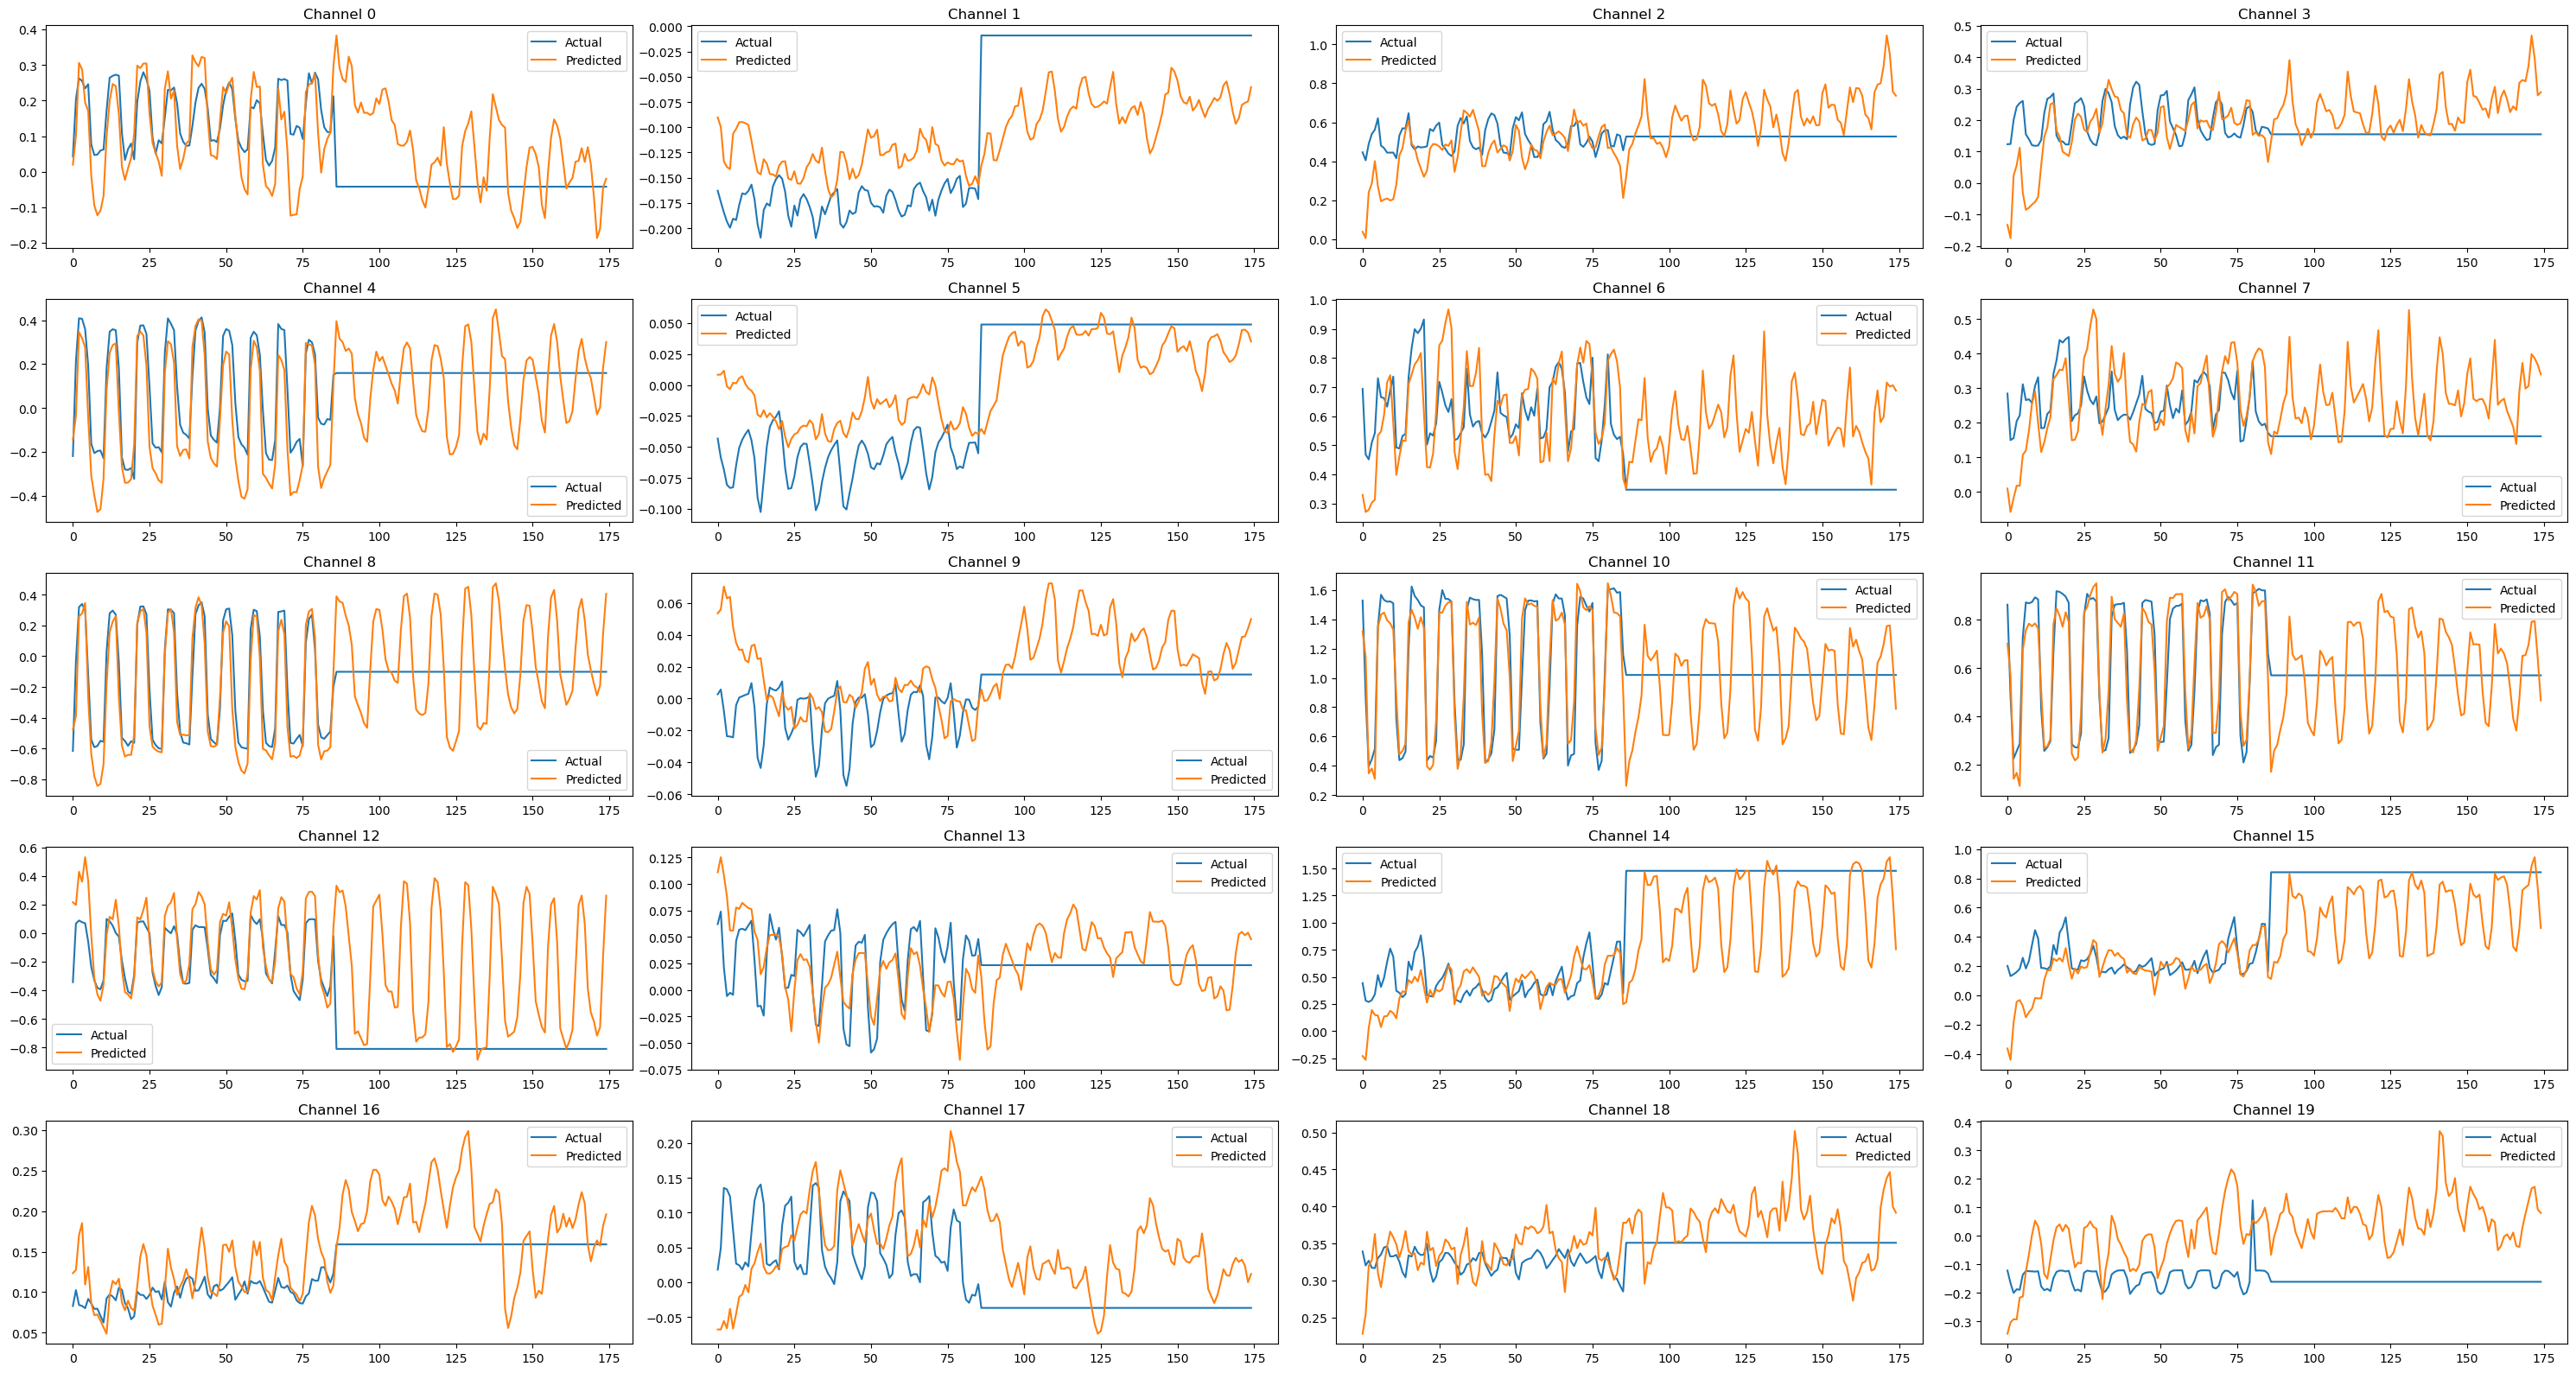

In [37]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(30, 16))

# axs - это 4x5 массив осей
axs = axs.flatten()  # Преобразуем в 1D для удобства

for i in range(20):
    axs[i].plot(y_test[-175:, i])
    axs[i].plot(preds_stream[-175:, i])
    axs[i].set_title(f'Channel {i}')
    axs[i].legend(['Actual', 'Predicted'])

plt.tight_layout()
plt.show()

In [1]:
import random
import os

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from torch.utils.data import TensorDataset, DataLoader

### Utils

In [2]:
# ---------------- UTILS ----------------

def train_test_split(data, N_parts, num_of_part):
    """Делит массив data на train/test по части в N_parts."""
    N_samples = len(data)
    split = int((N_samples * num_of_part) / N_parts)
    return data[:split], data[split:]


def slicer(data, label, fs, windowlen=500, timestep=100):
    """
    Нарезает данные на окна:
      data: (T, n_channels)
      label: (T, n_angles)
    Возвращает:
      slice_data: (n_windows, n_channels, windowlen_samples)
      slice_label: (n_windows, n_angles) — значение метки в момент конца окна.
    """
    T, n_ch = data.shape
    n_angles = label.shape[1]
    ts = int(timestep * fs / 1000)
    wl = int(windowlen * fs / 1000)
    # индексы старта каждого окна
    starts = np.arange(0, T - wl, ts)
    # построим окна
    slices = np.stack([data[s:s+wl].T for s in starts], axis=0)
    labs   = np.stack([label[s+wl]    for s in starts], axis=0)
    return slices, labs


def prepare_sequences(X, y, seq_len=5):
    """
    Из последовательности окон X и меток y формирует сдвигающиеся фрагменты длины seq_len.
      X: (n_windows, n_channels, n_times)
      y: (n_windows, n_angles)
    Возвращает:
      X_seq: (n_seq, seq_len, n_channels, n_times)
      y_seq: (n_seq, seq_len, n_angles)
    """
    n_w, n_ch, n_t = X.shape
    _, n_ang = y.shape
    n_seq = n_w - seq_len + 1
    X_seq = np.zeros((n_seq, seq_len, n_ch, n_t), dtype=X.dtype)
    y_seq = np.zeros((n_seq, seq_len, n_ang), dtype=y.dtype)
    for i in range(n_seq):
        X_seq[i] = X[i:i+seq_len]
        y_seq[i] = y[i:i+seq_len]
    return X_seq, y_seq

# ---------------- ПАРАМЕТРЫ ----------------

# subj_path = "../data/Fedor_Jan/Preprocessed/"  # путь к .npz
subj_path = "..\\data\\Fedor\\Preprocessed\\1\\"
files = sorted(os.listdir(subj_path))

n_parts     = 10
train_parts = 8     # train на 8/10
fs          = 250   # частота съёмки
windowlen   = 256   # ms
timestep    = 200   # ms
seq_len     = 5     # длина истории

# списки для агрегации
X_train_list, y_train_list = [], []
X_test_list,  y_test_list  = [], []

# ---------------- ЧТЕНИЕ И НАРЕЗКА ----------------

for fn in files:
    data = np.load(os.path.join(subj_path, fn))
    emg   = data["data_myo"]     # (T, n_channels)
    ang   = data["data_angles"]  # (T, 20)

    # делим train/test по файлу
    emg_tr, emg_te = train_test_split(emg, n_parts, train_parts)
    ang_tr, ang_te = train_test_split(ang, n_parts, train_parts)

    # нарезаем окна
    X_tr, y_tr = slicer(emg_tr, ang_tr, fs, windowlen, timestep)
    X_te, y_te = slicer(emg_te, ang_te, fs, windowlen, timestep)

    X_train_list.append(X_tr)
    y_train_list.append(y_tr)
    X_test_list.append(X_te)
    y_test_list.append(y_te)

# конкатенируем по первому измерению
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test  = np.concatenate(X_test_list,  axis=0)
y_test  = np.concatenate(y_test_list,  axis=0)

print("После нарезки:")
print("  X_train:", X_train.shape)
print("  y_train:", y_train.shape)
print("  X_test: ", X_test.shape)
print("  y_test: ", y_test.shape)

# ---------------- СОЗДАНИЕ ПОСЛЕДОВАТЕЛЬНОСТЕЙ ----------------

# Для обучения: X_seq и y_seq включают seq_len меток,
# но наша модель предсказывает только последнюю метку,
# поэтому возьмём y_last = y_seq[:, -1, :].
X_train_seq, y_train_seq_full = prepare_sequences(X_train, y_train, seq_len)
X_test_seq,  y_test_seq_full  = prepare_sequences(X_test,  y_test,  seq_len)

# берем только последние метки из каждого фрагмента
y_train_seq = y_train_seq_full[:, -1, :]  # (n_seq, 20)
y_test_seq  = y_test_seq_full[:, -1, :]   # (n_seq, 20)

print("\nПосле формирования историй (seq_len=%d):" % seq_len)
print("  X_train_seq:", X_train_seq.shape)   # (n_seq, seq_len, n_ch, n_t)
print("  y_train_seq:", y_train_seq.shape)   # (n_seq, 20)
print("  X_test_seq: ", X_test_seq.shape)
print("  y_test_seq: ", y_test_seq.shape)

# ---------------- TORCH DATALOADERS ----------------

batch_size = 16

train_dataset = TensorDataset(
    torch.from_numpy(X_train_seq).float(),
    torch.from_numpy(y_train_seq).float()
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test_seq).float(),
    torch.from_numpy(y_test_seq).float()
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("\nDataLoaders готовы:")
print("  train_loader:", len(train_loader), "batch(es)")
print("  test_loader: ", len(test_loader),  "batch(es)")


После нарезки:
  X_train: (1419, 6, 64)
  y_train: (1419, 20)
  X_test:  (352, 6, 64)
  y_test:  (352, 20)

После формирования историй (seq_len=5):
  X_train_seq: (1415, 5, 6, 64)
  y_train_seq: (1415, 20)
  X_test_seq:  (348, 5, 6, 64)
  y_test_seq:  (348, 20)

DataLoaders готовы:
  train_loader: 89 batch(es)
  test_loader:  22 batch(es)


In [5]:
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

(torch.Size([16, 5, 6, 64]), torch.Size([16, 20]))

### Model

In [ ]:
class EMGRiemannRNN(nn.Module):
    def __init__(self, n_channels=8, hidden_size=128, num_layers=2, dropout=0.0,
                 cov_estimator='oas', metric='riemann'):
        super(EMGRiemannRNN, self).__init__()
        # Riemannian blocks (pyriemann, не обучаемые)
        self.cov = Covariances(estimator=cov_estimator)       # оценщик ковариаций
        self.ts = TangentSpace(metric=metric)                # проекция в касательное пространство
        # Размерность вектора после TangentSpace: n_channels*(n_channels+1)/2
        self.input_dim = n_channels * (n_channels + 1) // 2  
        # Рекуррентная сеть (GRU)
        self.rnn = nn.GRU(input_size=self.input_dim, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout=dropout)
        # Полносвязный слой для предсказания 20-мерного вектора углов
        self.fc = nn.Linear(hidden_size, 20)

    def forward(self, x_seq, hidden=None):
        """
        x_seq: тензор shape (batch, seq_len, n_channels, n_times)
        hidden: скрытое состояние RNN (None или tensor)
        Возвращает: (angles, new_hidden), где angles shape (batch, 20).
        """
        batch, seq_len, n_ch, t = x_seq.size()
        # Переформируем для вычисления ковариаций: (batch*seq_len, n_ch, t)
        x_flat = x_seq.view(batch * seq_len, n_ch, t)
        # Переносим на CPU и конвертируем в numpy для pyriemann
        x_np = x_flat.detach().cpu().numpy()
        # Вычисляем ковариационные матрицы (batch*seq_len, n_ch, n_ch)
        covmats = self.cov.transform(x_np)
        # Проекция в касательное пространство (batch*seq_len, input_dim)
        feats = self.ts.transform(covmats)
        # Возвращаем в тензор и на устройство (GPU/CPU)
        feat_tensor = torch.from_numpy(feats.astype('float32'))
        feat_tensor = feat_tensor.view(batch, seq_len, self.input_dim).to(x_seq.device)
        # Пропускаем через RNN
        rnn_out, new_hidden = self.rnn(feat_tensor, hidden)
        # Берём выход последнего шага последовательности
        last = rnn_out[:, -1, :]              # shape (batch, hidden_size)
        angles = self.fc(last)               # shape (batch, 20)
        return angles, new_hidden

# Пример создания модели
# model = EMGRiemannRNN(n_channels=8, hidden_size=128, num_layers=2, dropout=0.1)


In [ ]:
# Гиперпараметры
batch_size = 16
seq_len = 5
channels = 8
time_points = 64
hidden_size = 128
epochs = 10
learning_rate = 1e-3

# Инициализация модели, функции потерь, оптимизатора
model = EMGRiemannRNN(n_channels=channels, hidden_size=hidden_size, num_layers=2, dropout=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Пример датасета (случайные данные для демонстрации)
# X_train shape: (n_samples, seq_len, channels, time_points)
# Y_train shape: (n_samples, 20)
n_samples = 200
X_train = torch.randn(n_samples, seq_len, channels, time_points)
Y_train = torch.randn(n_samples, 20)
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Обучение
model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        optimizer.zero_grad()
        # Forward: hidden=None (начальное состояние)
        preds, _ = model(X_batch, hidden=None)
        loss = criterion(preds, Y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")